# Load dataset

In [23]:
labels = ['AF', 'N']

fs = 250

In [2]:
import os
# disable GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
    if filename.find("_all_") > -1 :
        filenames.append(filename)

In [3]:
filenames

['test_all_Conv_AE.csv',
 'test_all_Deep_AE.csv',
 'test_all_LSTM_AE.csv',
 'train_all_Conv_AE.csv',
 'train_all_Deep_AE.csv',
 'train_all_LSTM_AE.csv']

In [4]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight


In [10]:
train_Deep_AE_df = pd.read_csv(dataset_folder + "train_all_Deep_AE.csv", header=None)
train_Conv_AE_df = pd.read_csv(dataset_folder + "train_all_Conv_AE.csv", header=None)
train_LSTM_AE_df = pd.read_csv(dataset_folder + "train_all_LSTM_AE.csv", header=None)

test_Deep_AE_df = pd.read_csv(dataset_folder + "test_all_Deep_AE.csv", header=None)
test_Conv_AE_df = pd.read_csv(dataset_folder + "test_all_Conv_AE.csv", header=None)
test_LSTM_AE_df = pd.read_csv(dataset_folder + "test_all_LSTM_AE.csv", header=None)

## Dataset AFDB
Dataset AFDB terdiri dari 601 kolom, dimana kolom ke 601 merupakan katerori/class.

In [11]:
train_Deep_AE_df.head()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,600
0,0.632663,0.767789,0.864577,0.935467,0.944087,0.900276,0.708986,0.373540,0.154497,0.107304,...,4.121668e-05,1.831808e-04,1.492327e-04,1.696155e-04,9.824049e-05,5.592161e-06,5.138358e-06,5.632513e-06,2.992386e-06,0.0
1,0.895406,0.834951,0.683515,0.439529,0.158169,0.063812,0.064302,0.096957,0.161737,0.248660,...,4.696300e-05,4.625818e-05,3.124303e-05,4.354742e-05,6.636993e-05,2.027233e-04,2.749568e-04,2.060327e-04,1.761257e-04,0.0
2,0.913100,0.811433,0.537376,0.296211,0.150492,0.171120,0.200182,0.262127,0.338210,0.408961,...,4.343252e-06,6.086148e-06,6.629699e-06,6.188178e-06,2.562976e-06,8.765869e-08,2.100546e-07,1.182782e-07,8.957534e-08,0.0
3,0.942682,0.866716,0.560620,0.251827,0.101149,0.078799,0.090250,0.153481,0.217021,0.315786,...,1.264473e-08,1.074123e-07,7.949616e-08,1.399286e-07,1.324124e-07,1.086987e-08,1.479909e-08,2.243105e-08,2.324994e-08,0.0
4,0.942231,0.843043,0.447637,0.152531,0.062975,0.095698,0.129870,0.224229,0.349856,0.433476,...,9.701295e-10,2.182164e-08,9.076889e-09,1.920017e-08,1.955337e-08,1.722543e-09,1.340645e-09,3.830772e-09,3.773626e-09,0.0


In [12]:
train_Deep_AE_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33060 entries, 0 to 33059
Columns: 601 entries, 0 to 600
dtypes: float64(601)
memory usage: 151.6 MB


In [13]:
test_Deep_AE_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12906 entries, 0 to 12905
Columns: 601 entries, 0 to 600
dtypes: float64(601)
memory usage: 59.2 MB


In [25]:
def plot_noised_signal(signal, title="Sequence Signal"):
    time = np.arange(len(signal[0])) / fs
    
    plt.figure(figsize=(7,4)) 

    plt.plot(time, signal[0])
    plt.plot(time, signal[1])
    plt.legend(['channel 1', 'channel 2'])
    plt.title(title)
    plt.grid()

    plt.tight_layout()
    plt.show()

- Prepare training set dan test set

In [55]:
denoised = 'LSTM-AE' # isi dengan 'Deep-AE', 'Conv-AE', 'LSTM-AE' untuk memilih sumber dataset dari hasil denoising tsb.

train_df = train_Deep_AE_df if denoised == 'Deep-AE' else train_Conv_AE_df if denoised == 'Conv-AE' else train_LSTM_AE_df
test_df = test_Deep_AE_df if denoised == 'Deep-AE' else test_Conv_AE_df if denoised == 'Conv-AE' else test_LSTM_AE_df

In [56]:
target_train = train_df[600]
target_test = test_df[600]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [57]:
X_train=train_df.iloc[:,:600].values
X_test=test_df.iloc[:,:600].values

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

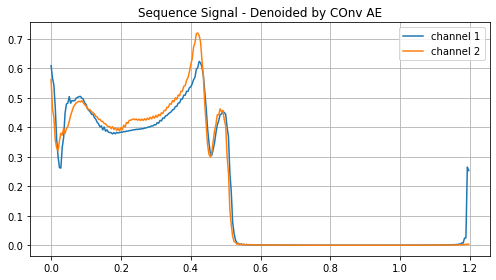

In [58]:
signal = np.reshape(X_train[0], (2, 300))

plot_noised_signal(signal, title="Sequence Signal - Denoided by COnv AE")

## Building Convolutional Neural Network

- Import Keras library

In [59]:
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import keras

- Buat CNN Model dengan aritektur network : 
`CONV-POOL-CONV-POOL-CONV-POOL-FC`
- CONV : 1D Convolutional Layer
- POOL : MAX Pooling Layer
- FC   : Dense Layer + Activation

In [60]:
def cnn_model(max_len):
    
    model = Sequential()
    
    model.add(Conv1D(filters=64,
                     kernel_size=6,
                     activation='relu',
                     input_shape=(max_len, 1)))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=3,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=6,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    model.add(Conv1D(filters=64,
                     kernel_size=3,
                     activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=2,
                        strides=2,
                        padding='same'))
    
    
    # Fully Connected layer (FC)
    model.add(Flatten())
    model.add(Dense(64, 
                    activation='relu'))
    model.add(Dense(32, 
                    activation='relu'))
    model.add(Dense(2, 
                    activation='softmax'))
              
    model.summary()
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

    return model

- sekarang kita akan melakukan proses training model dengan memanfaatkan `.fit()` pada model yang kita buat diatas.
- selain itu kita gunakan juka teknik `EarlyStoping()` untuk menghentikan proses training jika terjadi divergensi pada validation data yang diakibatkan oleh overfitting. 
- pada `EarlyStoping()` kita gunakan parmeter `patience=8` yang artinya jika proses training untuk 8 epoch tidak terjadi peningkatan maka hentikan proses training.

In [61]:
def check_model(model_, x, y, x_val, y_val, epochs_, batch_size_):
    callbacks = [EarlyStopping(monitor='val_loss', patience=3),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    hist = model_.fit(x, 
                      y,
                      epochs=epochs_,
                      callbacks=callbacks, 
                      batch_size=batch_size_,
                      validation_data=(x_val,y_val))
    model_.load_weights('best_model.h5')
    return hist 

### Train Model CNN

- jalankan proses training dengan `EPOCH` sebanyak 16 dan `BATCH_SIZE` sebesar 32

In [ ]:
max_len = X_train.shape[1]  

EPOCHS = 16
BATCH_SIZE = 32

model = cnn_model(max_len)
history=check_model(model, X_train,y_train,X_test,y_test, EPOCHS, BATCH_SIZE)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 595, 64)           448       
_________________________________________________________________
batch_normalization_7 (Batch (None, 595, 64)           256       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 298, 64)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 293, 64)           24640     
_________________________________________________________________
batch_normalization_8 (Batch (None, 293, 64)           256       
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 147, 64)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 145, 64)           12352     
__________

- Save model

In [47]:
model.save("CNN_Classification_model_%s.h5" % denoised)

- save model training history (log)

In [48]:
pd.DataFrame.from_dict(history.history).to_csv('history_train_classif_cnn_denoising_%s.csv' % denoised,index=False)

# Evaluate Model

- Plot Accuracy vs Epochs
- Plot Loss vs Epochs
- Plot Confusion Matrix

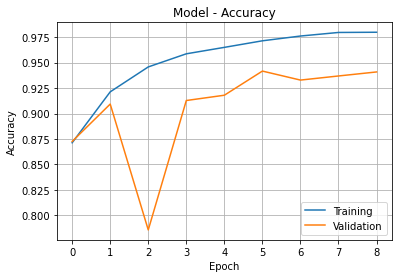

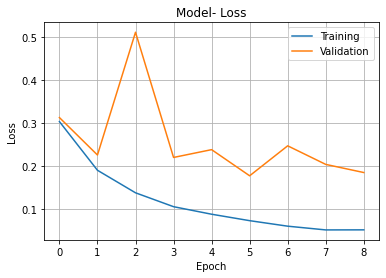

In [49]:
def evaluate_model(history, X_test, y_test):
    
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.grid()
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.grid()
    plt.show()

evaluate_model(history, X_test, y_test)    

- Dari hasil diatas kita bisa melihat jika akurasi training set = 0.99, sedangkan untuk akurasi validation set = 0.97
- Untuk plot loss training set = 0.01 sedangkan untuk loss validation set = 0.13

In [50]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5, 5))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

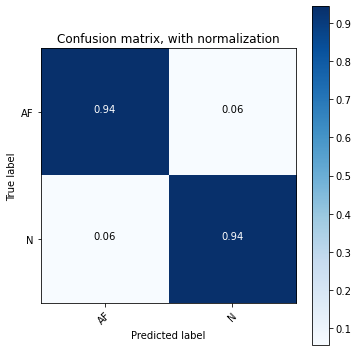

In [53]:
# predict test data
y_pred=model.predict(X_test)


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=['AF', 'N'],normalize=True,
                      title='Confusion matrix, with normalization')


- dari hasil plot confusion matrix, dapat dilihat tiap kelas memiliki banyak TRUE POSITIVE predicted data
- semakin gelap kebiruan menunjukan banyaknya hasil predicted label untuk true label tersebut

In [54]:
print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=['AF', 'N']))

              precision    recall  f1-score   support

          AF       0.94      0.94      0.94      6323
           N       0.94      0.94      0.94      6583

    accuracy                           0.94     12906
   macro avg       0.94      0.94      0.94     12906
weighted avg       0.94      0.94      0.94     12906



- Jika kita lihat, nilai report untuk seluruh klas juga bagus, 
- Nilai recall dan precission juga tinggi, menunjukan model mampu memprediksi data dengan baik untuk seluruh data pada sclass tersebut 